
Using the provided image-generation network, create a dataset of brain images that will later be used to train your chosen architecture.

Given that you will likely want to use this dataset multiple times during training, we recommend that you save the generated images to an appropriate folder in your GDrive.

Once you have generated your dataset, load and display ten of your generated images here.

We have also provided you with some corrupted images in the file `test_set.npy` of this repository. You should also load and display ten of these corrupted images here.

Below, we have provided template code, including some required downloads and installations, so that you can easily use the trained generative model. Sample generation in this model is done using the function `generate`, and is controlled by some input arguments. It is your job to figure out a sensible set of parameters that will produce images that are useful for the requirements of your task.

<br>

# Loading modules and set_seed and device

In [ ]:
import os
import sys

In [ ]:
!pip install livelossplot -q
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from torch.utils.data import Dataset
import os, glob
from PIL import Image
from torchvision.transforms import Compose, ToTensor, GaussianBlur, Resize, Grayscale, Lambda, transforms
from torchsummary import summary
from torchvision.utils import make_grid
from progressbar import ProgressBar
from livelossplot import PlotLosses

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True


def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")


Cuda installed! Running on GPU 0 NVIDIA L4!


# Diffusion model to generate brain images

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/cw1_files.zip -d ./
!chmod +x run.sh
!bash ./run.sh
sys.path.append('/content/ese-invldm')

Archive:  /content/drive/MyDrive/cw1_files.zip
  inflating: ./files/config_training.yml  
  inflating: ./run.sh                
  inflating: ./ese-invldm/setup.py   
  inflating: ./files/default_config.yml  
  inflating: ./ese-invldm/ese_invldm/ese_invldm.py  
  inflating: ./ese-invldm/ese_invldm/__init__.py  
  inflating: ./files/autoencoder/autoencoder_ckpt_latest.pth  
  inflating: ./files/diffusion/diffusion_ckpt_latest.pth  
Cloning the repository from https://github.com/dpelacani/InverseLDM.git...
Cloning into 'InverseLDM'...
remote: Enumerating objects: 1331, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 1331 (delta 167), reused 182 (delta 100), pack-reused 1070 (from 1)
Receiving objects: 100% (1331/1331), 467.16 KiB | 1.82 MiB/s, done.
Resolving deltas: 100% (875/875), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
from ese_invldm import generate

"""
Generates samples using a diffusion-based generative model.

This function leverages a pre-configured diffusion model to produce synthetic samples.
The sampling process supports adjustable parameters for total samples, inference steps, and batch size.
A scheduler and temperature can also be configured to control the sampling behaviour.

Parameters:
    num_samples (int):
        Total number of samples to generate.
    num_inference_steps (int):
        Number of diffusion inference steps.
        The minimum number of steps is 1, but we recommend exploring the range from 10 to 50.
        Please note that more steps will increase quality but also the computational cost. Be careful not
        to burn through your credits by using a very large number of steps!
    batch_size (int):
        Number of samples to process in each batch during sampling.
    scheduler (str, optional):
        Sampling scheduler to use (e.g., "ddim", "ddpm"). You can quickly test which one provides the most appropriate results
        for this task.
    temperature (float, optional):
        Sampling temperature to control randomness, given as a number between 0 and 1. Higher values produce more diverse outputs.
    seed (int, optional):
        Random seed for reproducibility. Defaults to 42.

Returns:
    list:
        A list containing the batches of generated samples, where each sample
        corresponds to a single data instance produced by the diffusion model.

"""
batch_size = 80
samples = generate(num_samples = 1440, num_inference_steps = 50, batch_size = batch_size, scheduler = 'ddim', temperature = 1)
#samples
#Used num_samples = 5 so that it does nto consume to much of my GPU and then adjusted based on that.
#samples = generate(num_samples = 5, num_inference_steps = 35, batch_size = 1, scheduler = 'ddim', temperature = 0.75)
#As a first remark and big panic, ddpm gave a sort of forest, whereas ddim gave a proper brain. More computational implies often more precise.
#Changing the num_inference_steps from 70 to 50 to 35 does not seem to change a lot, so kept num_inference_steps to 35.
#Why?

/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/content/InverseLDM/invldm/runners/base_runner.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. T

Batch 0


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


Batch 1


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 2


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 3


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 4


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 5


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 6


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 7


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 8


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 9


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 10


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 11


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 12


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 13


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 14


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 15


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 16


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch 17


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


In [ ]:
samples[1].shape

torch.Size([80, 1, 64, 64])

(1, 64, 64)


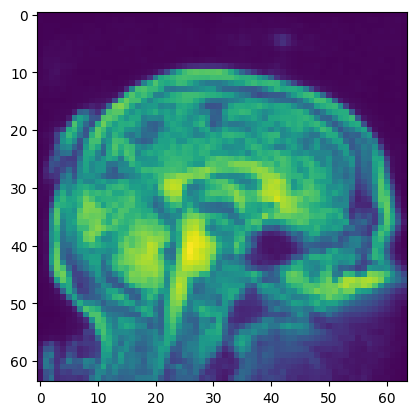

In [ ]:
#Want to put the samples into images. How?
#type(samples) == list but type(samples[0]) = tensor
#Make the mistake below. What we want is not that. It's just that we have a list of tensors!
##### sample = samples[0] #became a tensor as it was a list before

#samples.shape #torch.Size([10, 1, 64, 64])
first_image = samples[0][0].cpu().detach().numpy()
#type(first_image) #numpy.ndarray
#first_image.shape = (1, 64, 64)
print(first_image.shape)
#frist_image = first_image.squeeze() #For some obscure reason, doing first_image = first_image.squeeze() does not change the shape.
plt.imshow(first_image.squeeze()) #Hence it is done here

# Putting images to drive and creating a new_sample.
Altough it will not be used, as the iamges are a bit corrupted when they are saved for reasons that I don't know. Most probably putting them in png or resizing them impacts them, but further investigations on the cause of that need to be made

In [ ]:
save_folder = '/content/drive/My Drive/Assessment_Images'
os.makedirs(save_folder, exist_ok=True) #Create the folder

In [ ]:
#Using pillow appeared much easier, as pl.savefig, despite the changes done, was always returning images that were not 64 times 64 in size.
index = 1
for batch in samples:
    for sample in batch:
      image = sample.cpu().detach().numpy().squeeze() # for imread to work
      # Normalize the image to [0, 255] and convert to uint8
      image = (image - image.min()) / (image.max() - image.min()) * 255
      image = image.astype(np.uint8) #Need that otherwise we wont we image to use Image

      # Save the image using Pillow
      img = Image.fromarray(image)
      #img = img.resize((64, 64))  # Ensure the image is resized to 64x64
      img.save(f'{save_folder}/image_{index}.png')
      index += 1

In [ ]:
image_files = sorted([os.path.join(save_folder, f) for f in os.listdir(save_folder) if f.endswith('.png')])

In [ ]:
new_samples = []
batch = []
for index, path in enumerate(image_files):
    # Read the image and convert it to a tensor
    image = imread(path)  # Load the image
    image_tensor = torch.from_numpy(np.array(image)).float()  # Convert to tensor as we will have lists
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    # Add the image tensor to the batch
    batch.append(image_tensor)

    if ((index + 1) % batch_size) == 0:
        new_tensor = torch.cat(batch, dim=0)  # Shape: [batch_size, 1, 64, 64]
        new_samples.append(new_tensor)
        batch = []  # Reset the batch


In [ ]:
new_samples[0].shape

torch.Size([80, 1, 64, 64])

# Loading corrupted_images

Now, let's go on the corrupted images.
First thing we do is understanding what are npy files. Found this reference, that will be put in reference file but that is put here for clarity of reasoning.  # https://stackoverflow.com/questions/53084637/how-do-you-open-npy-files

In [ ]:
# first we need to go on the local machine and read it directly.
os.getcwd()
#instead, I put it on my google colab drive.
#The path is /test_set.npy
#os.chdir('/test_set.npy') #fail obviously
# numpy_file = '/content/drive/My Drive/Colab Notebook' #Error because I forgot to put an 's' to notebooks... -10 minutes. But we enjoy.

'/content'

In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/test_set.npy'
corrupted_data = np.load(file_path)

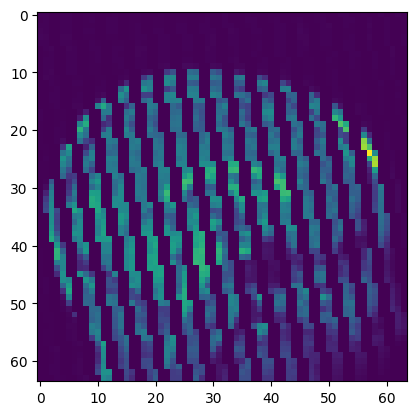

In [ ]:
plt.imshow(corrupted_data[0].squeeze()) # We got our first image!!!

As we can see, the image is traversed by multiple lines.

The task is to create a mask that will apply the same lines to our generated imaes.

So that afterward we will be able to create a model that works on those corrupted images.

Thing is that now, we want to train on more than one hundred images for our train set.

So we will generate 500 training images. We will do it once obviously regarding our CPU, and after having trained our model on 10 images.

As we have been told: begin with simple, end with complicated

In [ ]:
image_files[0:40]

['/content/drive/My Drive/Assessment_Images/image_1.png',
 '/content/drive/My Drive/Assessment_Images/image_10.png',
 '/content/drive/My Drive/Assessment_Images/image_100.png',
 '/content/drive/My Drive/Assessment_Images/image_1000.png',
 '/content/drive/My Drive/Assessment_Images/image_1001.png',
 '/content/drive/My Drive/Assessment_Images/image_1002.png',
 '/content/drive/My Drive/Assessment_Images/image_1003.png',
 '/content/drive/My Drive/Assessment_Images/image_1004.png',
 '/content/drive/My Drive/Assessment_Images/image_1005.png',
 '/content/drive/My Drive/Assessment_Images/image_1006.png',
 '/content/drive/My Drive/Assessment_Images/image_1007.png',
 '/content/drive/My Drive/Assessment_Images/image_1008.png',
 '/content/drive/My Drive/Assessment_Images/image_1009.png',
 '/content/drive/My Drive/Assessment_Images/image_101.png',
 '/content/drive/My Drive/Assessment_Images/image_1010.png',
 '/content/drive/My Drive/Assessment_Images/image_1011.png',
 '/content/drive/My Drive/Asses

In [ ]:
images = [imread(file) for file in image_files]

Coming from our Google drive file. We can see that putting them in png for or simply going through the process of being saved slightly changed them, based on the comparison between new_sample(from GDrive) and sample.

# Test for plotting
## We choose cmap gray as we have medical images

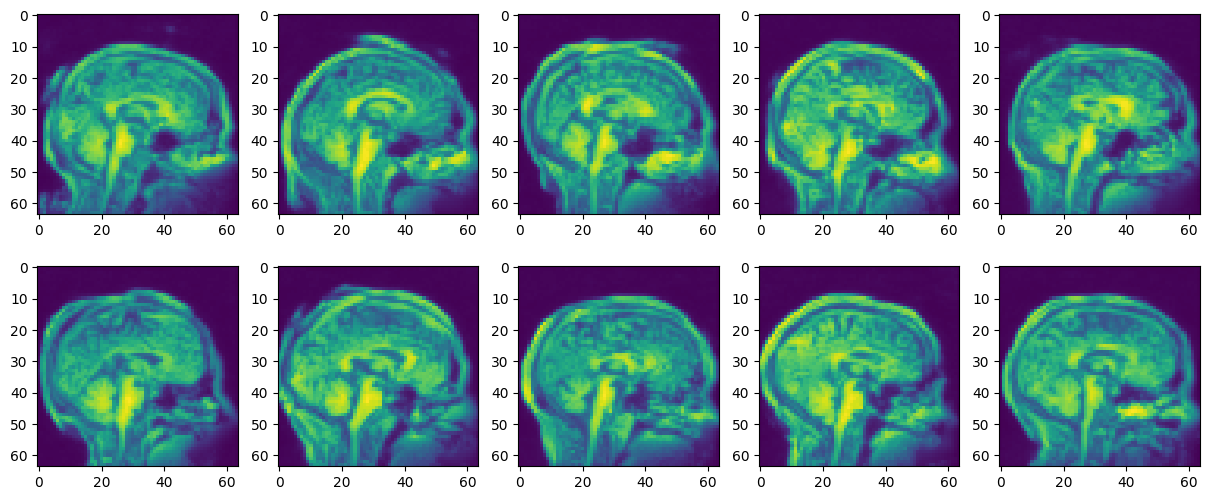

In [ ]:
fig, axs = plt.subplots(2, 5, figsize = (15, 6))
axs = axs.flatten()
for index, ax in enumerate(axs):
    # Convert the tensor to CPU, detach, and convert to NumPy
    image = new_samples[0][index].cpu().detach().numpy().squeeze()
    image = image.squeeze()
    # Save the image using plt.imshow
    ax.imshow(image)
    # plt.axis('off')  # Turn off axes
plt.show()

The 10 images of the two folders are displayed below:

Uncorrupted images generated by the generator

# Plotting required

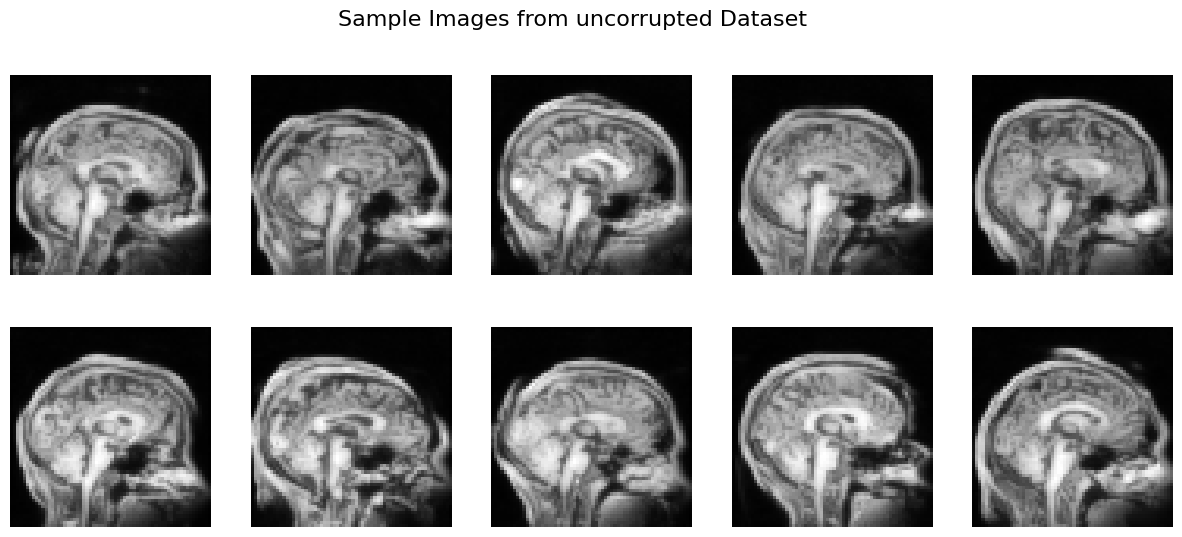

In [335]:
fig, axs = plt.subplots(2, 5, figsize = (15, 6))
fig.suptitle("Sample Images from uncorrupted Dataset", fontsize=16)
axs = axs.flatten()
for index, ax in enumerate(axs):
    # Convert the tensor to CPU, detach, and convert to NumPy
    image = samples[0][index].cpu().detach().numpy().squeeze()
    image = image.squeeze()
    # Save the image using plt.imshow
    ax.imshow(image, cmap = 'gray')
    ax.axis('off')  # Turn off axes


Our corrutped images

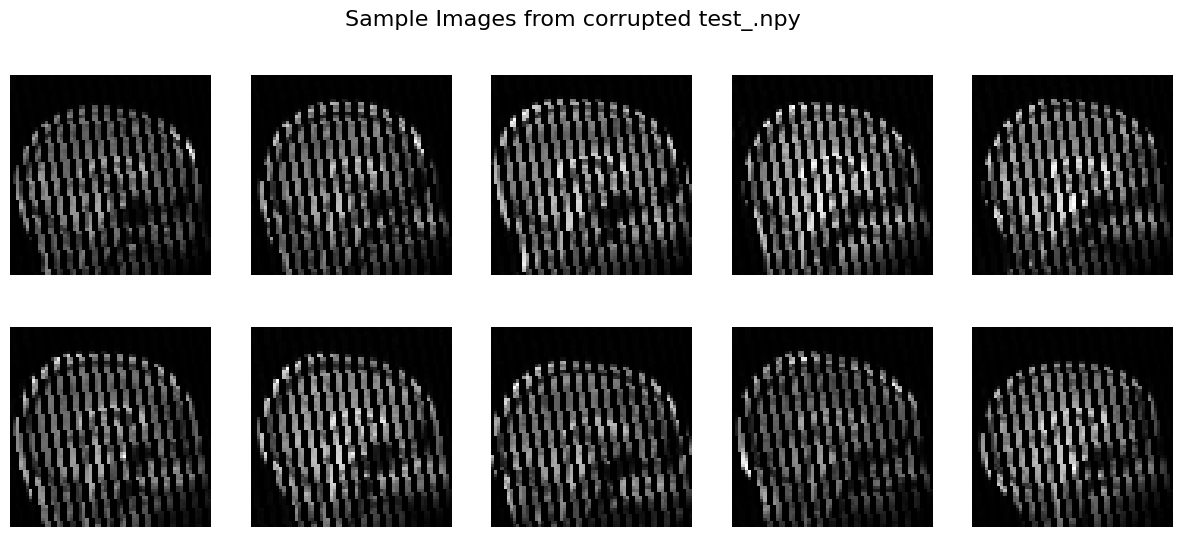

In [334]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample Images from corrupted test_.npy", fontsize=16)
axs = axs.flatten()
for index, ax in enumerate(axs):  # need to send the weights to the cpu for plotting
  #print(data[index].shape)
  ax.imshow(corrupted_data[index].squeeze(), cmap = 'gray')
  ax.axis('off')



<br>

---

<br>

Using the data generated, create a PyTorch `TensorDataset` and a `DataLoader` for the training set.

Using the provided corrupted images inside `test_set.npy`, create another `TensorDataset` and a `DataLoader` for the test set.

The training dataset should provide batches of brain images generated in and should corrupt these images appropriately so that they resemble images in the test set. The dataset should also pair each image with its corresponding un-corrupted image as a label.

The test dataset should provide the corrupted images provided, for which no labels are available.

Display here ten images of your training dataset and ten images of your test dataset, and their corresponding labels when available.

<br>



# Sample of a corrupted image

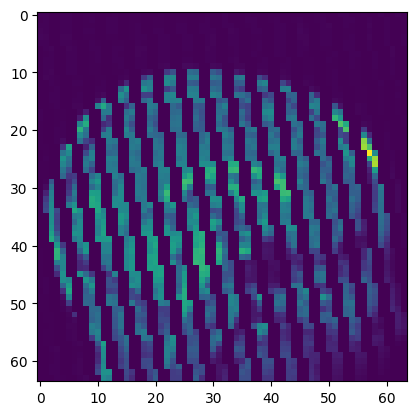

In [ ]:
plt.imshow(corrupted_data[0].squeeze())

In [ ]:
# print(data[0].squeeze()[20])
# print(data[0].squeeze()[21])
# print(data[0].squeeze()[22])

## Applying the mask for one image

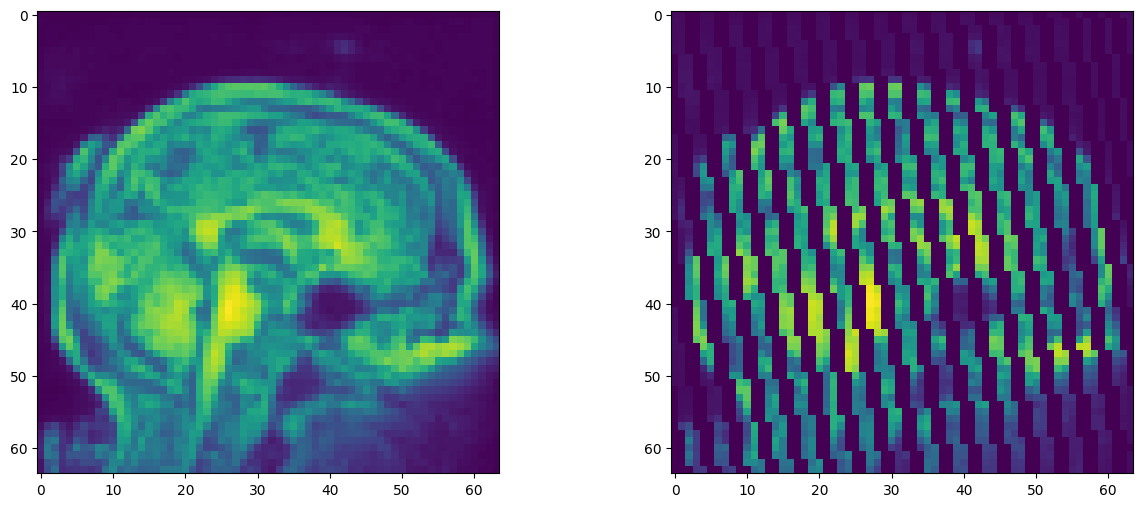

In [ ]:
#creating our mask
fig, axs = plt.subplots(1, 2, figsize = (15, 6))
image_c = corrupted_data[0].squeeze() # numpy array
sample_image = samples[0][0].cpu().detach().numpy()
sample_image = sample_image.squeeze().squeeze()
axs[0].imshow(sample_image)

for i in range(64):
  for j in range(64):
    if image_c[i][j] == 0:
      sample_image[i][j] = 0

axs[1].imshow(sample_image)

## Creating the mask that we will be put as a global variable later

In [ ]:
mask = np.ones((64, 64))
for i in range(64):
  for j in range(64):
    if image_c[i][j] == 0:
      mask[i][j] = 0

In [ ]:
sample_image = new_samples[0][0].cpu().detach().numpy()
sample_image = sample_image.squeeze().squeeze()
#new_image = np.matmul(sample_image, mask), we want to multiply element wise
corrupted_image = np.multiply(sample_image, mask)

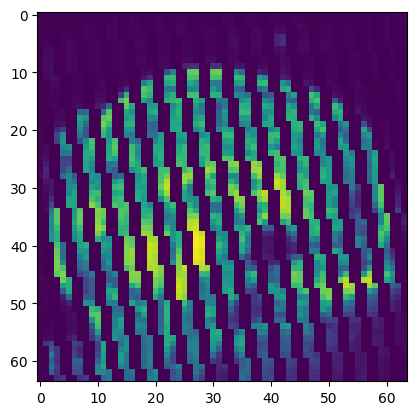

In [ ]:
plt.imshow(corrupted_image)

# Create Brain_train(Dataset)

In [ ]:
#set mask as a global variable # numpy array
class Brain_train(Dataset):
    global mask
    def __init__(self, images_uncorrupted, split="train"):
        self.images_unccorupted = images_uncorrupted
        self.split = split
        if split == "train":
          self.data = images_uncorrupted[0:int(len(images_uncorrupted)*0.75//1)]
        elif split == "validation":
          self.data = images_uncorrupted[int(len(images_uncorrupted)*0.75//1):]
        else:
          raise ValueError("split parameter must be 'train' or 'validation'")

    def _get_mask(self):
        return mask

    def __getitem__(self, idx):
        sample_image = self.data[idx]
        sample_image = sample_image.cpu().detach().numpy().squeeze().squeeze()
        corrupted_image = np.multiply(sample_image, mask)
        return sample_image, corrupted_image

    def display(self, idx_):
        sample_image, corrupted_image = self.__getitem__(idx_)
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(sample_image)
        axs[1].imshow(corrupted_image)
        return

    def __len__(self):
        return len(self.data)

    def __str__(self):

        return 'Train images and their correspond corruptions, of a brain, generated using a diffusion model '

In [ ]:
train_dataset = Brain_train(samples, split="train")
valid_dataset = Brain_train(samples, split= 'validation')

In [ ]:
train_dataset.__str__()

'Train images and their correspond corruptions, of a brain, generated using a diffusion model '

13
2


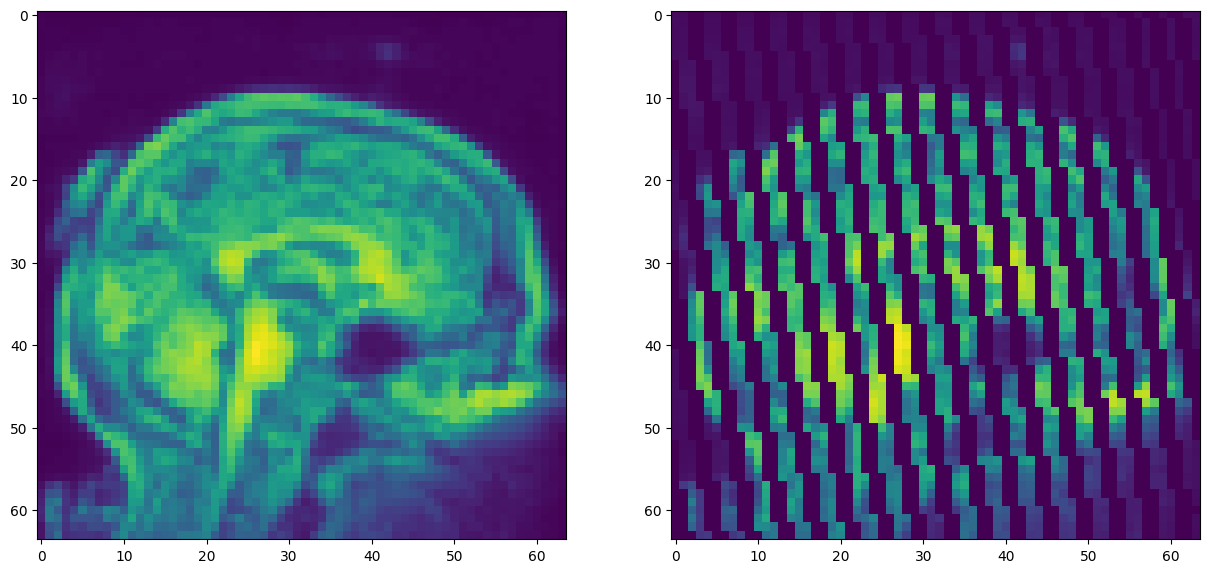

In [ ]:
print(train_dataset.__len__()) #11 batches
print(len(train_dataset[1])) # 2 big list with corrupted and uncorrupted for each batch
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
axs[0].imshow(train_dataset[0][0][0]) #uncorrupted
axs[1].imshow(train_dataset[0][1][0]) #corrupted


In [ ]:
corrupted_data.shape

(100, 1, 64, 64)

# Create Brain_test(Dataset)

In [ ]:
#set mask as a global variable # numpy array
class Brain_test(Dataset):
    global mask
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def display(self, idx_):
        plt.imshow(self.__getitem__(idx_).squeeze())
        return

    def __len__(self):
        return len(self.data)

    def __str__(self):
        return 'Corrupted brain images on which we will apply our model'

## Test

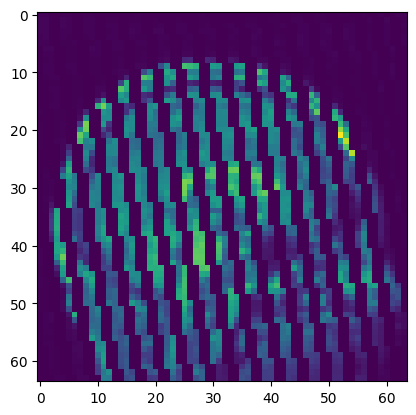

In [ ]:
test_dataset = Brain_test(corrupted_data)
test_dataset.display(1)

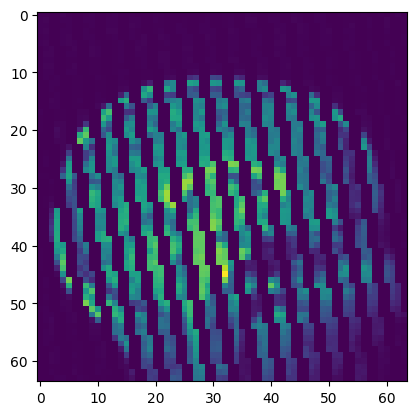

In [ ]:
for i in range(10):
  plt.imshow(test_dataset[i].squeeze())

# Confirmation that my train_loader has a good output.
Finally, got 2 [13, 80, 64, 64], first corrupted, second for uncorrupted

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

torch.Size([13, 80, 1, 64, 64])
torch.Size([13, 80, 1, 64, 64])


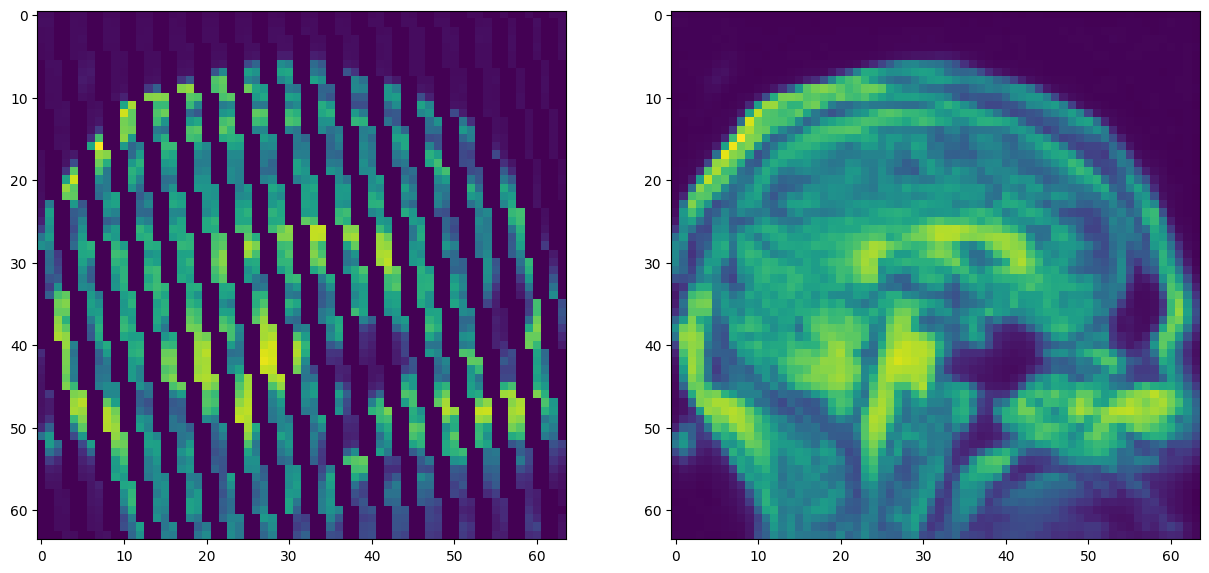

In [ ]:
sample_batch = next(iter(train_loader))
uncorrupted = sample_batch[0]
corrupted = sample_batch[1]
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
axs[0].imshow(corrupted[0][1])
axs[1].imshow(uncorrupted[0][1])
uncorrupted = uncorrupted.unsqueeze(2)
corrupted = corrupted.unsqueeze(2)
print(uncorrupted.shape)
print(corrupted.shape)

In [ ]:
print(uncorrupted.shape, corrupted.shape)

torch.Size([13, 80, 1, 64, 64]) torch.Size([13, 80, 1, 64, 64])


# Plotting the images required

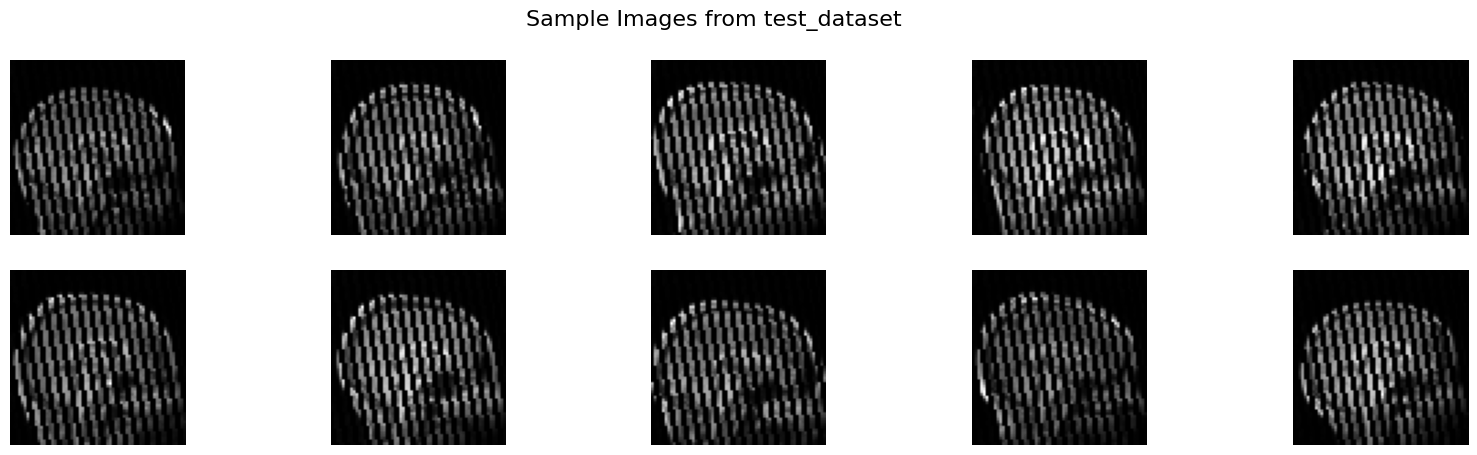

In [333]:
# Create a grid with 2 rows: one for uncorrupted, one for corrupted
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
fig.suptitle("Sample Images from test_dataset", fontsize=16)
axs = axs.flatten()
for i in range(10):
  axs[i].imshow(test_dataset[i].squeeze(), cmap = 'gray')# as we have IRM images, which are always in gray scale
  axs[i].axis('off')



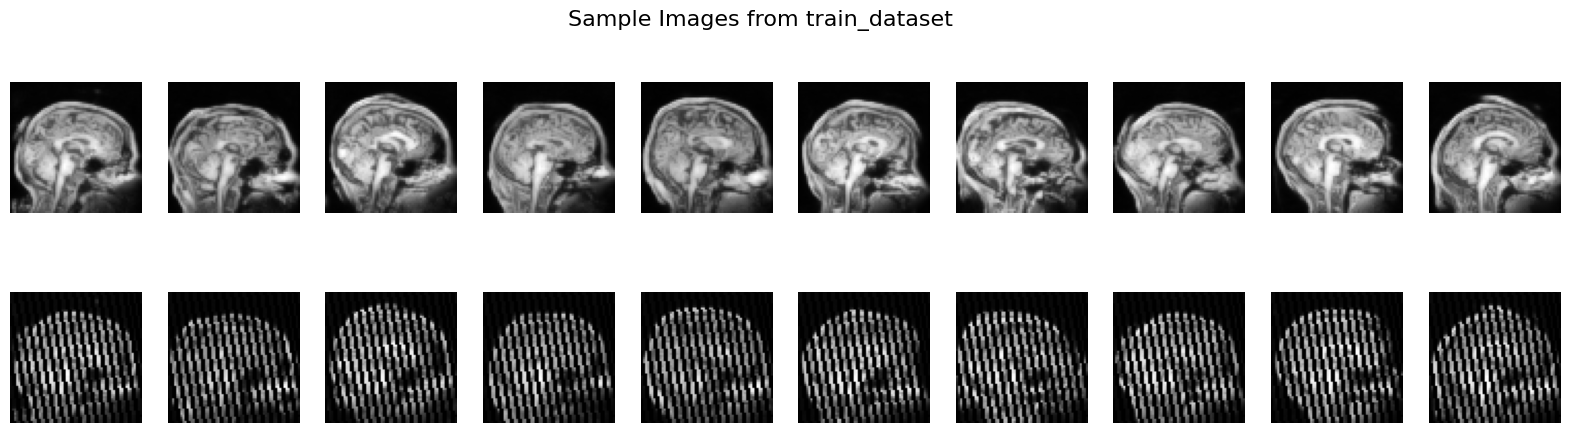

In [332]:
# Create a grid with 2 rows: one for uncorrupted, one for corrupted
fig, axs = plt.subplots(2, 10, figsize=(20, 5))
fig.suptitle("Sample Images from train_dataset", fontsize=16)

for i in range(10):
    # Uncorrupted images
    axs[0, i].imshow(train_dataset[0][0][i], cmap = 'gray')
    axs[0, i].axis('off')

    # Corrupted images
    axs[1, i].imshow(train_dataset[0][1][i], cmap = 'gray')
    axs[1, i].axis('off')



Using the dataset created in , design and train an architecture to recover the missing image lines of the provided test dataset.

Once you have trained your architecture, display here ten images of the test set with the recovered lines filled in.

Additionally, save the test data with the missing values filled in into a numpy file called `test_set_nogaps.npy`. These images should be **in the same order** as those in the `test_set.npy` file and should have the same pixel size of 64x64. **Any images not contained in the `test_set_nogaps.npy` file or incorrectly ordered will not be marked.**

You have freedom to choose an architecture that you consider appropriate to solve this problem. However, you will need to train your chosen architecture as part of the assessment: **pre-trained networks are not allowed**.

You will be assessed by the quality of your predictions of the missing data values and additional marks will be given for originality in your network design choices. You should include, as part of your answer, a paragraph explaining the architecture you have chosen and any additional design choices and hyperparameters that have been important to build your solution.

This is an open-book assessment and you are encouraged to use resources online, including  tools like chatGPT. However, make sure to always mention the sources for your code and ideas, including websites, papers, and tools like chatGPT.

<br>


torch.Size([13, 80, 1, 64, 64])
torch.Size([13, 80, 1, 64, 64])


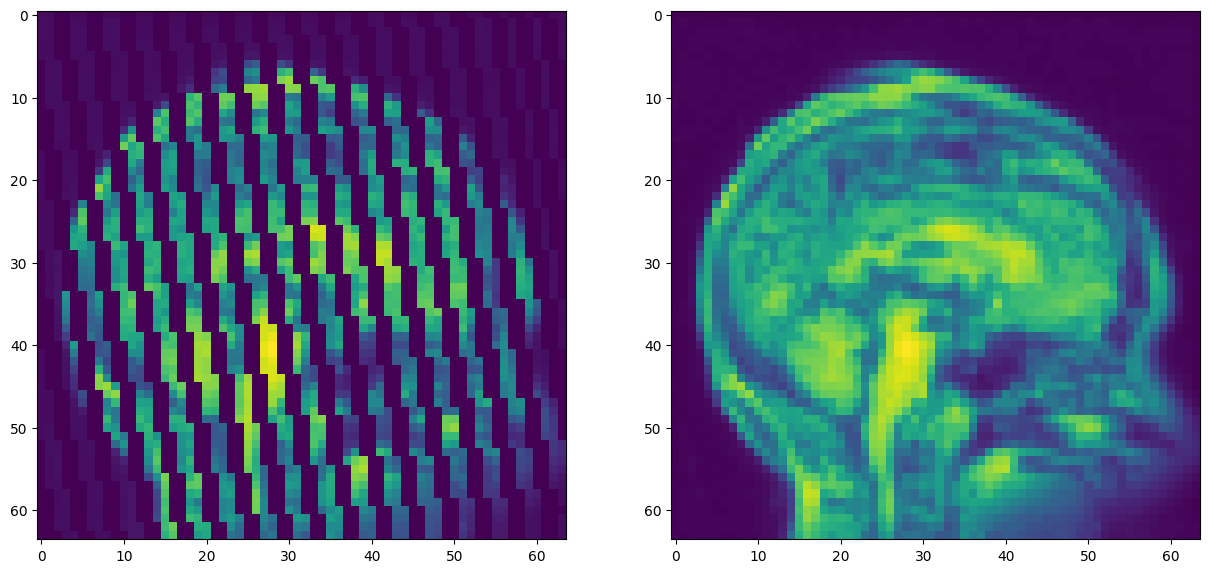

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

sample_batch = next(iter(train_loader))
uncorrupted = sample_batch[0]
corrupted = sample_batch[1]
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
axs[0].imshow(corrupted[1][1])
axs[1].imshow(uncorrupted[1][1])
uncorrupted = uncorrupted.unsqueeze(2)
corrupted = corrupted.unsqueeze(2)
print(uncorrupted.shape)
print(corrupted.shape)

# Simple Autoencoder (not retained)

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            # Input: (batch_size, 1, 64, 64)
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),  #(batch_size, 64, 64, 64)
            nn.ReLU(),  #(batch_size, 64, 64, 64)
            nn.MaxPool2d(kernel_size=2, stride=2),  #(batch_size, 64, 32, 32)

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  #(batch_size, 128, 32, 32)
            nn.ReLU(),  #(batch_size, 128, 32, 32)
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 128, 16, 16)

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  #(batch_size, 256, 16, 16)
            nn.ReLU(),  #(batch_size, 256, 16, 16)
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(

            # Input: (batch_size, 256, 16, 16)
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),  #(batch_size, 128, 16, 16)
            nn.ReLU(),  #(batch_size, 128, 16, 16)
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),  #(batch_size, 64, 32, 32)
            nn.ReLU(),  #(batch_size, 64, 32, 32)
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2),  #(batch_size, 1, 64, 64)
            nn.Sigmoid()  #(batch_size, 1, 64, 64) with pixel values in [0, 1]
        )

    def forward(self, x):
        # Forward through encoder
        x = self.encoder(x)
        #print('here')
        # Forward through decoder
        x = self.decoder(x)
        return x


In [ ]:
model_1 = DenoisingAutoencoder().to(device)
epochs = 60
lr = 1e-3
wd = 1e-6
optimiser_1 = torch.optim.Adam(params=model_1.parameters(), lr=lr, weight_decay=wd)
criterion = nn.MSELoss()

In [331]:
epochs = 100
# corrupted = corrupted / 255.0
# uncorrupted = uncorrupted / 255.0
for epoch in range(epochs):
    model_1.train()
    train_loss = 0
    for noisy, clean in zip(corrupted, uncorrupted):
        noisy, clean = noisy.to(torch.float32), clean.to(torch.float32)
        noisy, clean = noisy.to(device), clean.to(device)
        #print(type(noisy))

        # Forward pass
        outputs = model_1(noisy)
        loss_1 = criterion(outputs, clean)

        # Backward pass and optimization
        optimiser_1.zero_grad()
        loss_1.backward()
        optimiser_1.step()

        train_loss += loss_1.item()
    #print(train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader):.4f}")


Epoch [1/100], Loss: 0.0213
Epoch [2/100], Loss: 0.0211
Epoch [3/100], Loss: 0.0210
Epoch [4/100], Loss: 0.0209
Epoch [5/100], Loss: 0.0207
Epoch [6/100], Loss: 0.0204
Epoch [7/100], Loss: 0.0203
Epoch [8/100], Loss: 0.0202
Epoch [9/100], Loss: 0.0202
Epoch [10/100], Loss: 0.0201
Epoch [11/100], Loss: 0.0200
Epoch [12/100], Loss: 0.0199
Epoch [13/100], Loss: 0.0197
Epoch [14/100], Loss: 0.0196
Epoch [15/100], Loss: 0.0195
Epoch [16/100], Loss: 0.0194
Epoch [17/100], Loss: 0.0194
Epoch [18/100], Loss: 0.0192
Epoch [19/100], Loss: 0.0192
Epoch [20/100], Loss: 0.0191
Epoch [21/100], Loss: 0.0190
Epoch [22/100], Loss: 0.0189
Epoch [23/100], Loss: 0.0188
Epoch [24/100], Loss: 0.0187
Epoch [25/100], Loss: 0.0187
Epoch [26/100], Loss: 0.0186
Epoch [27/100], Loss: 0.0186
Epoch [28/100], Loss: 0.0186
Epoch [29/100], Loss: 0.0186
Epoch [30/100], Loss: 0.0184
Epoch [31/100], Loss: 0.0182


KeyboardInterrupt: 

torch.Size([1, 64, 64])


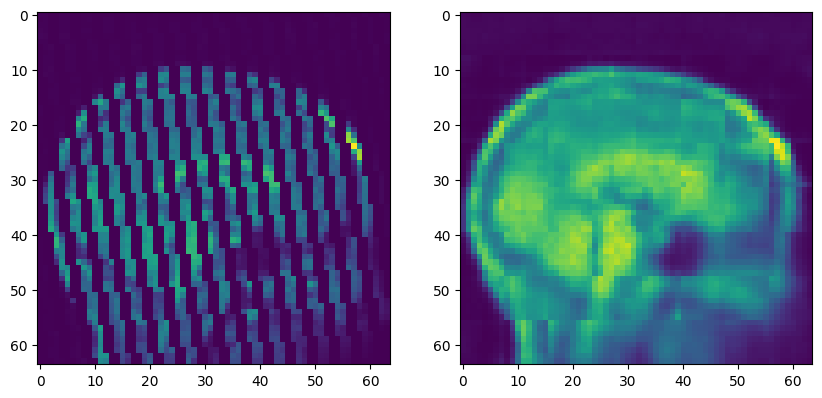

In [ ]:
ex_corr = corrupted_data[0]
fig, axs = plt.subplots(1, 2, figsize = (10,6))
axs[0].imshow(ex_corr.squeeze())
ex_corr = torch.from_numpy(ex_corr)
ex_corr = ex_corr.to(device)
ex_unc = model_1(ex_corr)
print(ex_unc.shape) #torch.Size([1, 64, 64])
ex_unc = ex_unc.squeeze().cpu().detach().numpy()
axs[1].imshow(ex_unc.squeeze())

# Unet 2

In [311]:
class UNet2(nn.Module):
    def __init__(self):
        super(UNet2, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(1, 64)  # Input: 1 channel (grayscale), Output: 64 channels
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.up4 = self.upconv_block(1024, 512)
        self.dec4 = self.conv_block(1024, 512)

        self.up3 = self.upconv_block(512, 256)
        self.dec3 = self.conv_block(512, 256)

        self.up2 = self.upconv_block(256, 128)
        self.dec2 = self.conv_block(256, 128)

        self.up1 = self.upconv_block(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

        # Max pooling
        self.max_pool2d = nn.MaxPool2d(2)

    def conv_block(self, in_channels, out_channels):
        # Convolutional block with two convolutional layers
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def upconv_block(self, in_channels, out_channels):
        # Transpose convolution for upsampling
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)  # Shape: [batch, 64, H, W]
        x2 = self.max_pool2d(enc1)  # Downsample
        enc2 = self.enc2(x2)  # Shape: [batch, 128, H/2, W/2]
        x3 = self.max_pool2d(enc2)  # Downsample
        enc3 = self.enc3(x3)  # Shape: [batch, 256, H/4, W/4]
        x4 = self.max_pool2d(enc3)  # Downsample
        enc4 = self.enc4(x4)  # Shape: [batch, 512, H/8, W/8]

        # Bottleneck
        bottleneck = self.bottleneck(self.max_pool2d(enc4))  # Shape: [batch, 1024, H/16, W/16]

        # Decoder with skip connections
        up4 = self.up4(bottleneck)  # Upsample to match enc4
        x4 = torch.cat((up4, enc4), dim=1)  # Concatenate along channel axis
        x4 = self.dec4(x4)

        up3 = self.up3(x4)  # Upsample to match enc3
        x3 = torch.cat((up3, enc3), dim=1)
        x3 = self.dec3(x3)

        up2 = self.up2(x3)  # Upsample to match enc2
        x2 = torch.cat((up2, enc2), dim=1)
        x2 = self.dec2(x2)

        up1 = self.up1(x2)  # Upsample to match enc1
        x1 = torch.cat((up1, enc1), dim=1)
        x1 = self.dec1(x1)

        # Final output layer
        out = torch.sigmoid(self.final_conv(x1))
        return out


# Test

In [313]:
model_2 = UNet2().to(device)
lr = 1e-3
wd = 1e-6
optimiser_2 = torch.optim.Adam(params=model_2.parameters(), lr=lr, weight_decay=wd)
criterion_2 = nn.MSELoss() #nn.L1Loss()

In [ ]:
corrupted.shape, uncorrupted.shape

(torch.Size([13, 80, 1, 64, 64]), torch.Size([13, 80, 1, 64, 64]))

In [314]:
epochs = 100
for epoch in range(epochs):
    model_2.train()
    train_loss_2 = 0
    for noisy_, clean_ in zip(corrupted, uncorrupted):
        #print(noisy.shape)
        noisy_, clean_ = noisy_.to(torch.float32), clean_.to(torch.float32)
        noisy_, clean_ = noisy_.to(device), clean_.to(device)
        #print(type(noisy))
        #print(torch.equal(corrupted, uncorrupted)) # false

        # Forward pass
        outputs_ = model_2(noisy_)
        loss_2 = criterion_2(outputs_, clean_)
        #print(outputs.shape)

        # Backward pass and optimization
        optimiser_2.zero_grad()
        loss_2.backward()
        #check for gradients. Event though are gradients are small, our network is still learning, which is a sign that there are not affecting the network.
        # for name, param in model_2.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name} - Gradient Mean: {param.grad.mean().item():.6f}, Gradient Max: {param.grad.max().item():.6f}")

        optimiser_2.step()
        #print(train_loss_2)
        train_loss_2 += loss_2.item()
    #print(train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss_2/len(train_loader):.4f}")

Epoch [1/100], Loss: 0.5690
Epoch [2/100], Loss: 0.1518
Epoch [3/100], Loss: 0.0690
Epoch [4/100], Loss: 0.0372
Epoch [5/100], Loss: 0.0258
Epoch [6/100], Loss: 0.0206
Epoch [7/100], Loss: 0.0173
Epoch [8/100], Loss: 0.0152
Epoch [9/100], Loss: 0.0144
Epoch [10/100], Loss: 0.0133
Epoch [11/100], Loss: 0.0125
Epoch [12/100], Loss: 0.0112
Epoch [13/100], Loss: 0.0109
Epoch [14/100], Loss: 0.0109
Epoch [15/100], Loss: 0.0103
Epoch [16/100], Loss: 0.0097
Epoch [17/100], Loss: 0.0094
Epoch [18/100], Loss: 0.0090
Epoch [19/100], Loss: 0.0088
Epoch [20/100], Loss: 0.0087
Epoch [21/100], Loss: 0.0085
Epoch [22/100], Loss: 0.0086
Epoch [23/100], Loss: 0.0087
Epoch [24/100], Loss: 0.0081
Epoch [25/100], Loss: 0.0079
Epoch [26/100], Loss: 0.0077
Epoch [27/100], Loss: 0.0076
Epoch [28/100], Loss: 0.0075
Epoch [29/100], Loss: 0.0074
Epoch [30/100], Loss: 0.0075
Epoch [31/100], Loss: 0.0075
Epoch [32/100], Loss: 0.0073
Epoch [33/100], Loss: 0.0071
Epoch [34/100], Loss: 0.0070
Epoch [35/100], Loss: 0

There seems to be multiple local minimums in the functions. The most optimal learning rate, found without grid search, is lr = 1e-3
4 convolutional blocks , bicubic, 0.031
5 convolutional blocks, bicubic, 0.0178
Adding more layers does not improve the model. This may be due to the fact our image is 64*64, so does not have intricate patterns to learn.
However, adding more convolutional layers within each blocks may imporve the mode.  
We know try to change the ReLu() for a more complex type, and
)

Compare our two results

# Simple Autoencoder result

torch.Size([1, 64, 64])


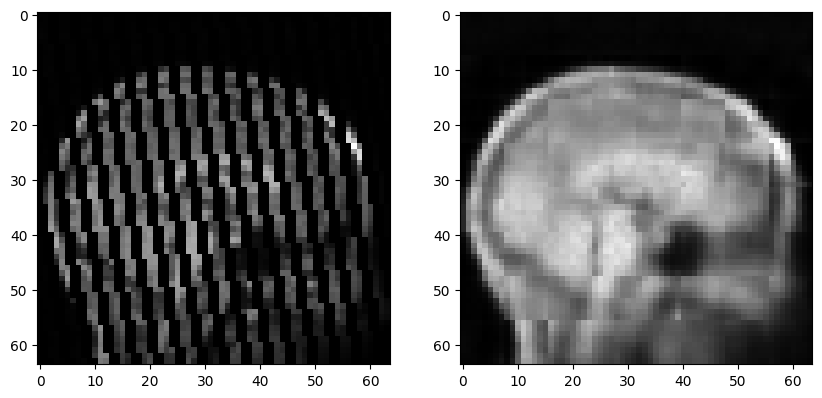

In [328]:
ex_corr = corrupted_data[0]
fig, axs = plt.subplots(1, 2, figsize = (10,6))
axs[0].imshow(ex_corr.squeeze(), cmap = 'gray')
ex_corr = torch.from_numpy(ex_corr)
ex_corr = ex_corr.to(device)

ex_unc = model_1(ex_corr)
print(ex_unc.shape) #torch.Size([1, 64, 64])
ex_unc = ex_unc.squeeze().cpu().detach().numpy()
axs[1].imshow(ex_unc.squeeze(), cmap = 'gray')

# The complicate model that performed more poorly that the classic UNet

In [ ]:

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(1, 64)  # Input: 1 channel (grayscale), Output: 64 channels
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.dec4 = self.upconv_block(1024 + 512, 512)
        self.dec3 = self.upconv_block(512 + 256, 256)
        self.dec2 = self.upconv_block(256 + 128, 128)
        self.dec1 = self.upconv_block(128 + 64, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            self.conv_block(out_channels, out_channels),
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder
        dec4 = self.dec4(torch.cat((F.interpolate(bottleneck, scale_factor=2, mode='bicubic', align_corners=True), enc4), dim=1))
        dec3 = self.dec3(torch.cat((F.interpolate(dec4, scale_factor=2, mode='bicubic', align_corners=True), enc3), dim=1))
        dec2 = self.dec2(torch.cat((F.interpolate(dec3, scale_factor=2, mode='bicubic', align_corners=True), enc2), dim=1))
        dec1 = self.dec1(torch.cat((F.interpolate(dec2, scale_factor=2, mode='bicubic', align_corners=True), enc1), dim=1))

        # Final output
        out = torch.sigmoid(self.final_conv(dec1))
        return out

# U-Net result

torch.Size([1, 1, 64, 64])


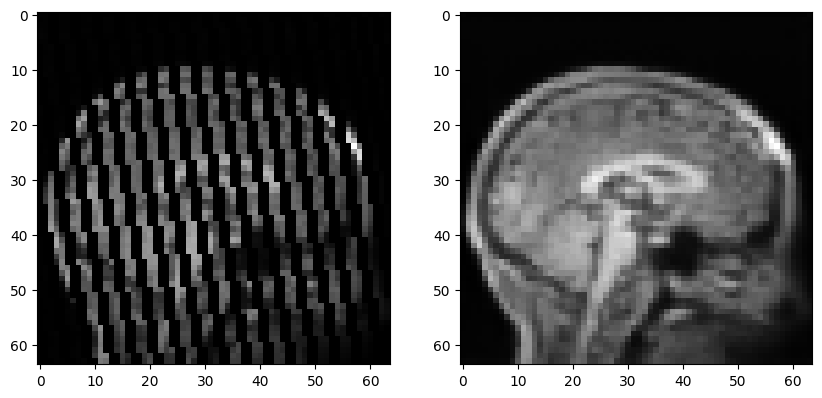

In [330]:
ex_corr_2 = corrupted_data[0]
fig, axs = plt.subplots(1, 2, figsize = (10,6))
axs[0].imshow(ex_corr_2.squeeze(), cmap = 'gray')
ex_corr_2 = torch.from_numpy(ex_corr_2)
ex_corr_2 = ex_corr_2.to(device)

ex_unc_2 = model_2(ex_corr_2.unsqueeze(0))
print(ex_unc_2.shape) #torch.Size([1, 64, 64])
ex_unc_2 = ex_unc_2.squeeze().cpu().detach().numpy()
axs[1].imshow(ex_unc_2.squeeze(), cmap = 'gray')

# Learning curve try but fails for device reasons most probably

In [301]:
def validate(model, criterion, val_loader):
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for batch_idx, (corrupted, uncorrupted) in enumerate(val_loader):
            corrupted = corrupted.view(-1, 1, 64, 64)
            uncorrupted = uncorrupted.view(-1, 1, 64, 64)

            corrupted, uncorrupted = corrupted.to(torch.float32), uncorrupted.to(torch.float32)
            corrupted, uncorrupted = corrupted.to(device), uncorrupted.to(device)

            # Forward pass
            output = model(corrupted)

            # Compute loss
            loss = criterion(output, uncorrupted)

            validation_loss += loss.item()


    return validation_loss / len(val_loader)  # Average loss


In [302]:
def train(model, train_loader, criterion, optimiser, epochs):
    liveloss = PlotLosses()
    logs = {
        "train_loss": [],
        "val_loss": []
    }
    model.train()

    for epoch in range(epochs):
        total_loss = 0

        for batch_idx, (corrupted, uncorrupted) in enumerate(train_loader):
            # print('here2')
            corrupted = corrupted.view(-1, 1, 64, 64)
            uncorrupted = uncorrupted.view(-1, 1, 64, 64)

            corrupted, uncorrupted = corrupted.to(torch.float32), uncorrupted.to(torch.float32)
            #otherwise RuntimeError: Input type (c10::Half) and bias type (float) should be the same as
            #input parameters and model parameters need to be the same
            corrupted, uncorrupted = corrupted.to(device), uncorrupted.to(device)

            optimiser.zero_grad()

            output = model(corrupted) #  Forward pass

            loss = criterion(output, uncorrupted)
            loss.backward()
            optimiser.step()

            total_loss += loss.item()

            #if batch_idx % 10 == 0:
                #print(f"Train Epoch: {epoch + 1}/{epochs} "
                      # f"[{batch_idx * corrupted.size(0)}/{len(train_loader.dataset)}]\t"
                      # f"Loss: {loss.item():.6f}")
        total_loss /= len(train_loader)
        logs['train_loss'] = train_loss
        validation_loss = validate(model=model_2, criterion=criterion_2, val_loader=valid_loader)
        logs['val_loss'] = validation_loss
        liveloss.update(logs)
        liveloss.draw()

        avg_loss = total_loss
        print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss:.6f}")
    return total_loss

# for epoch in range(epochs):
#     logs = {}

#     train_loss = train(model=model_2, train_loader=train_loader , criterion=criterion_2, optimiser=optimiser_2, epochs = epochs)


#     validation_loss = validate(model=model_2, criterion=criterion_2, val_loader=valid_loader)
#     logs['val_' + 'log loss'] = validation_loss

#     liveloss.update(logs)
#     liveloss.draw()



In [303]:
train_loss = train(model=model_2, train_loader=train_loader , criterion=criterion_2, optimiser=optimiser_2, epochs = 30)

Epoch 1/30 - Average Loss: 0.079527
Epoch 2/30 - Average Loss: 0.028298
Epoch 3/30 - Average Loss: 0.023704
Epoch 4/30 - Average Loss: 0.028927
Epoch 5/30 - Average Loss: 0.029677
Epoch 6/30 - Average Loss: 0.029765
Epoch 7/30 - Average Loss: 0.029775
Epoch 8/30 - Average Loss: 0.029777
Epoch 9/30 - Average Loss: 0.029777
Epoch 10/30 - Average Loss: 0.029777
Epoch 11/30 - Average Loss: 0.029777
Epoch 12/30 - Average Loss: 0.029777
Epoch 13/30 - Average Loss: 0.029777
Epoch 14/30 - Average Loss: 0.029777
Epoch 15/30 - Average Loss: 0.029777
Epoch 16/30 - Average Loss: 0.029777
Epoch 17/30 - Average Loss: 0.029777
Epoch 18/30 - Average Loss: 0.029777
Epoch 19/30 - Average Loss: 0.029777
Epoch 20/30 - Average Loss: 0.029777
Epoch 21/30 - Average Loss: 0.029777
Epoch 22/30 - Average Loss: 0.029777
Epoch 23/30 - Average Loss: 0.029777
Epoch 24/30 - Average Loss: 0.029777
Epoch 25/30 - Average Loss: 0.029777
Epoch 26/30 - Average Loss: 0.029777
Epoch 27/30 - Average Loss: 0.029777
Epoch 28/3

In [ ]:
# ex_corr = corrupted_data[0]
# # fig, axs = plt.subplots(1, 2, figsize = (10,6))
# axs[0].imshow(ex_corr.squeeze())
# ex_corr = torch.from_numpy(ex_corr)
# ex_corr = ex_corr.to(device)
# ex_unc = model(ex_corr)
# print(ex_unc.shape) #torch.Size([1, 64, 64])
# ex_unc = ex_unc.squeeze().cpu().detach().numpy()
# axs[1].imshow(ex_unc.squeeze())

KeyboardInterrupt: 

In [ ]:
ex_corr = corrupted_data[0]
fig, axs = plt.subplots(1, 2, figsize = (10,6))
axs[0].imshow(ex_corr.squeeze())
ex_corr = torch.from_numpy(ex_corr)
ex_corr = ex_corr.to(device)
ex_unc = model(ex_corr)
print(ex_unc.shape) #torch.Size([1, 64, 64])
ex_unc = ex_unc.squeeze().cpu().detach().numpy()
axs[1].imshow(ex_unc.squeeze())

In [ ]:
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

# sample_batch = next(iter(train_loader))
# uncorrupted = sample_batch[0]
# corrupted = sample_batch[1]
# fig, axs = plt.subplots(1, 2, figsize = (15, 10))
# axs[0].imshow(corrupted[0][1])
# axs[1].imshow(uncorrupted[0][1])
# uncorrupted = uncorrupted.unsqueeze(2)
# corrupted = corrupted.unsqueeze(2)
# print(uncorrupted.shape)
# print(corrupted.shape)


In [ ]:
corrupted_data.shape # 100
type(corrupted_data) #numpy.ndarray
#corrupted_data = np.load(file_path)
type(corrupted_data[0]), corrupted_data[0].shape

# Sample image

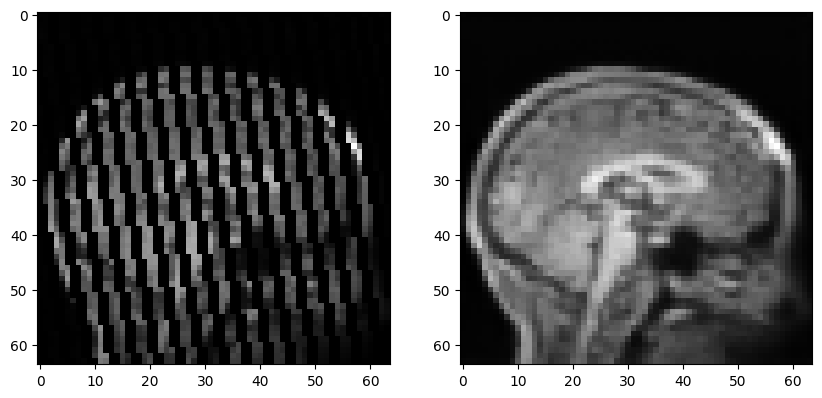

In [319]:
ex_corr_2 = corrupted_data[0]
fig, axs = plt.subplots(1, 2, figsize = (10,6))
axs[0].imshow(ex_corr_2.squeeze(), cmap = 'gray')
ex_corr_2 = torch.from_numpy(ex_corr_2)
ex_corr_2 = ex_corr_2.to(device)

ex_unc_2 = model_2(ex_corr_2.unsqueeze(0))
#print(ex_unc_2.shape) #torch.Size([1, 64, 64])
ex_unc_2 = ex_unc_2.squeeze().cpu().detach().numpy()
axs[1].imshow(ex_unc_2.squeeze(), cmap = 'gray')

In [ ]:
uncorrupted_final = []
for image in corrupted_data:
  #print(i.shape)
  image = torch.from_numpy(image)
  image = image.to(device)
  unc_image = model_2(image)
  unc_image = unc_image.squeeze().cpu().detach().numpy()
  uncorrupted_final.append(unc_image)

  #uncorrupted_final(plt.imshooutp
np.save('test_set_nogaps.npy', uncorrupted_final)

# Plotting the 10 recovered images as asked in the question

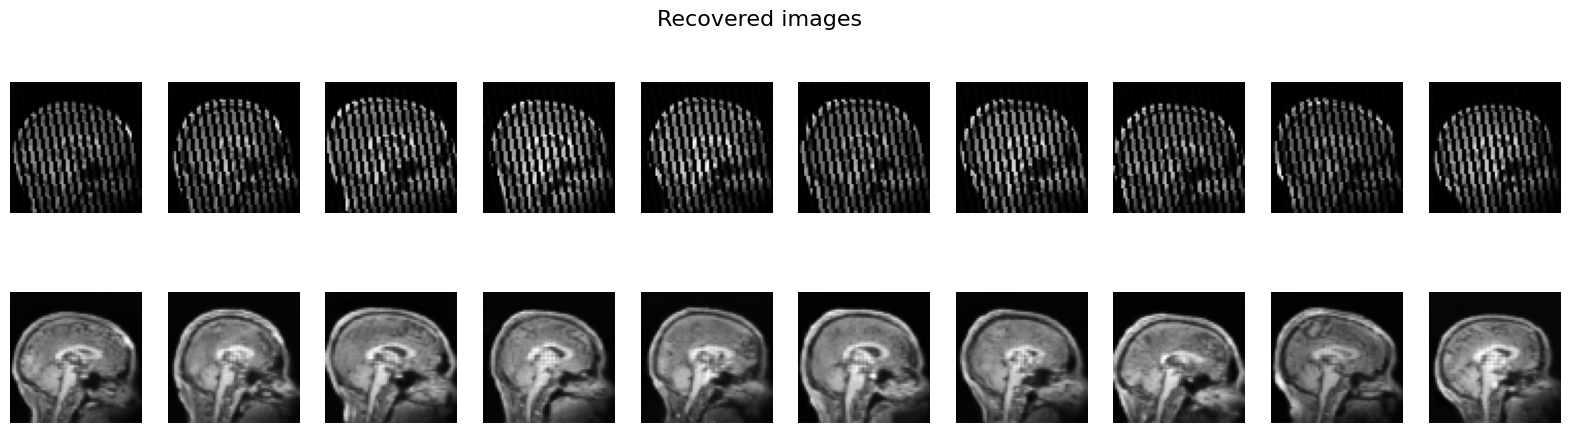

In [321]:
fig, axs = plt.subplots(2, 10, figsize=(20, 5))
fig.suptitle("Recovered images", fontsize=16)
for i in range(10):
    ex_corr_2 = corrupted_data[i]
    axs[0, i].imshow(ex_corr_2.squeeze(), cmap = 'gray')
    axs[0, i].axis('off')
    ex_corr_2 = torch.from_numpy(ex_corr_2)
    ex_corr_2 = ex_corr_2.to(device)

    ex_unc_2 = model_2(ex_corr_2.unsqueeze(0))
    ex_unc_2 = ex_unc_2.squeeze().cpu().detach().numpy()

    # Corrupted images
    axs[1, i].imshow(ex_unc_2.squeeze(), cmap = 'gray')
    axs[1, i].axis('off')

# Putting to test_set_nogaps.npy

In [322]:
uncorrupted_final = np.load('/content/test_set_nogaps.npy')
uncorrupted_final.shape

(100, 64, 64)

In [323]:
uncorrupted_final[0:10]

array([[[0.01385149, 0.01428875, 0.01379483, ..., 0.01331109,
         0.01606261, 0.01340645],
        [0.0152615 , 0.01502588, 0.01373909, ..., 0.0160262 ,
         0.01730114, 0.01493529],
        [0.01642943, 0.0154159 , 0.01507156, ..., 0.01559314,
         0.01741568, 0.01462617],
        ...,
        [0.01530142, 0.01658842, 0.01600663, ..., 0.01758887,
         0.01842997, 0.0152557 ],
        [0.01583294, 0.01887338, 0.01755671, ..., 0.01769356,
         0.01727723, 0.01342116],
        [0.01908056, 0.02077143, 0.01361218, ..., 0.01581171,
         0.01253159, 0.012655  ]],

       [[0.01326194, 0.01366946, 0.01317436, ..., 0.01336075,
         0.01618667, 0.01352096],
        [0.01457482, 0.0143561 , 0.01310468, ..., 0.01610309,
         0.01743242, 0.01508776],
        [0.01613326, 0.01501908, 0.01458076, ..., 0.01564352,
         0.01757123, 0.01476765],
        ...,
        [0.01263515, 0.01578775, 0.01442653, ..., 0.01785814,
         0.01666347, 0.01339053],
        [0.0

This is not perfect. But it is okay. It works.
It is now 12:17, we have 3 hours for hyperparameter tuning!
Process will be to add convolutional layer blokcs, as it appear that the model is not taking into account the full complexity of the image. Adding more layer blocks may maybe enhance the process.  
I choose as a baseline the interpolation method 'bilinear'. But we will change it with the 2 other possible methods: 'nearest and bicubic.

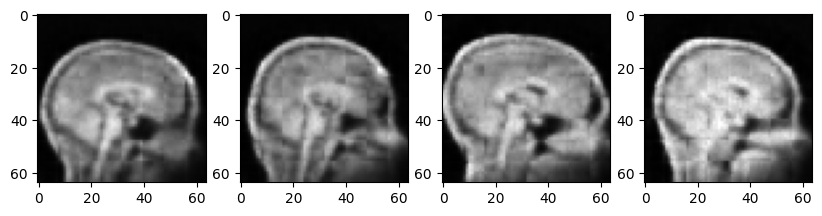

In [325]:
n = 4
fig, axs = plt.subplots(1, n, figsize= (10, 6))
for index, image in enumerate(uncorrupted_final[:n]):
  axs[index].imshow(image, cmap = 'gray')

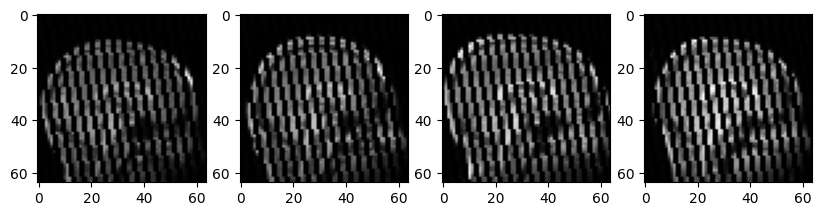

In [326]:
n = 4
fig, axs = plt.subplots(1, n, figsize= (10, 6))
for index, image in enumerate(corrupted_data[:n]):
  axs[index].imshow(image.squeeze(), cmap = 'gray')

# Choice of my model

I will be honest here. After having tried to usee more and more andm ore complex model: adding convolutional layers, mixing sstrategies of concatenations, changing the non-linear activation, I found that a good old U-net from https://arxiv.org/pdf/1505.04597 performed much better, and was easier to use. WE could think that usnig Unet++ or U-net attention could work better, but given time costraints, we chose to not go into them.